In [63]:
import eniric
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from eniric.atmosphere import Atmosphere
from eniric.Qcalculator import rv_precision
from eniric.Qcalculator import quality
%matplotlib notebook

In [2]:
hdu = fits.open('car-20160325T05h28m38s-sci-gtoc-nir_A_input_TAC.fits')
data_tell = hdu[1].data
wave = data_tell['WAVE'] *0.1  #(nm)
flux_in = data_tell['SPEC']
flux_corr = data_tell['tacflux']
trans = data_tell['mtrans']
wave

array([ 960.35718938,  960.36252636,  960.3678628 , ..., 1711.83438953,
       1711.83983238, 1711.84527414])

In [ ]:
# Write the transmission file
with open('mtrans_carmenes.txt', 'w') as f:
    for wl, fl in zip(wave, trans):
        f.write("{} {}\n".format(wl,fl))

In [76]:
# Computing RV precision and Quality
# --
# Changing the atmospheric model from TAPAS to Molecfit
eniric.atmmodel["base"] = 'mtrans_car-20160325T05h28m38s'
# Defining the bands
bands = ["Y", "J", "H"]
Y_mask = (wave > 999.6668) & (wave < 1100.366)
J_mask = (wave > 1169.61 ) & (wave < 1330.443)
H_mask = (wave > 1499.5) &  (wave < 1750.583)
band_masks = [Y_mask, J_mask, H_mask]
# Loop over the bands
# plt.figure()
for band, b_mask in zip(bands, band_masks):
    print('\nBand', band, '\n-------')
    print('RV precision')
    # Removing zeros flux points
    mask = b_mask & (flux_corr > 0.)
    atm = Atmosphere.from_band(band, bary=False)
    # Obtain closest telluric model values at the wavelength values (telluric mask is super sampled).
    atm = atm.at(wave[mask])
    # Mask the transmission below given depth. e.g. 2%
    # atm.mask_transmission(2.0)
    # Masking +- 30km/s the telluric lines
    rv_mask_tell = rv_precision(wave[mask], flux_in[mask], mask=atm.mask)
    # Corrected tellurics with Molecfit weighted by the transmission
    rv_corr_tell = rv_precision(wave[mask], flux_corr[mask])
    print('input flux, atm mask: ', rv_mask_tell, ' > masking the tellurics'
      '\ncorr flux, trans mask:', rv_corr_tell, ' > telluric correction')
    print('\nQuality')
    q_mask_tell = quality(wave[mask], flux_in[mask])
    q_corr_tell = quality(wave[mask], flux_corr[mask])
    print('input flux, atm mask: ', q_mask_tell, 
          '\ncorr flux, trans mask:', q_corr_tell)
    print('ATM mask', atm.mask)
    # plt.plot(wave[mask], atm.mask)
    # plt.plot(wave[mask], flux_in[mask])
# plt.axvspan(999.6668, 1100.366, alpha=0.2)
# plt.axvspan(1169.61, 1330.443, alpha=0.2)
# plt.axvspan(1499.5, 1750.583, alpha=0.2)


Band Y 
-------
RV precision
input flux, atm mask:  414.7686017052313 m / s  > masking the tellurics
corr flux, trans mask: 430.4798342549599 m / s  > telluric correction

Quality
input flux, atm mask:  5097.767620690646 
corr flux, trans mask: 4895.178208608088
ATM mask [ True  True  True ...  True  True  True]

Band J 
-------
RV precision
input flux, atm mask:  274.5418725225658 m / s  > masking the tellurics
corr flux, trans mask: 486.8714976394476 m / s  > telluric correction

Quality
input flux, atm mask:  7924.2570733053335 
corr flux, trans mask: 4377.679133205857
ATM mask [ True  True  True ...  True  True  True]

Band H 
-------
RV precision
input flux, atm mask:  325.157158366 m / s  > masking the tellurics
corr flux, trans mask: 413.67149051610085 m / s  > telluric correction

Quality
input flux, atm mask:  7228.357104573289 
corr flux, trans mask: 5620.729242782737
ATM mask [ True  True  True ...  True  True  True]


<IPython.core.display.Javascript object>


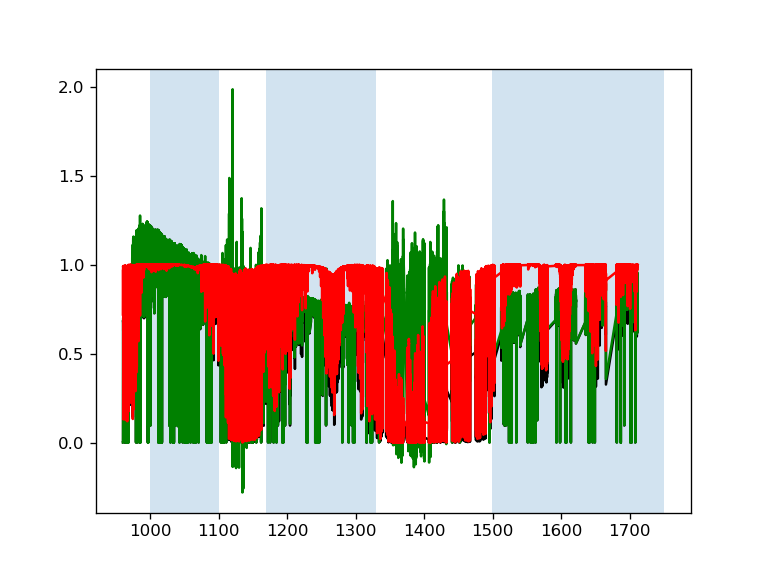

In [77]:
plt.figure()
wl_mask = J_mask
# plt.plot(wave[mask], flux_in[mask])
plt.plot(wave, flux_in, 'k-', label='Input')
plt.plot(wave, flux_corr, 'g-', label='Corrected')
plt.plot(wave, data_tell['mtrans'], 'r-', label='Trans')
plt.axvspan(999.6668, 1100.366, alpha=0.2)
plt.axvspan(1169.61, 1330.443, alpha=0.2)
plt.axvspan(1499.5, 1750.583, alpha=0.2)
# plt.legend()

0.8


<IPython.core.display.Javascript object>


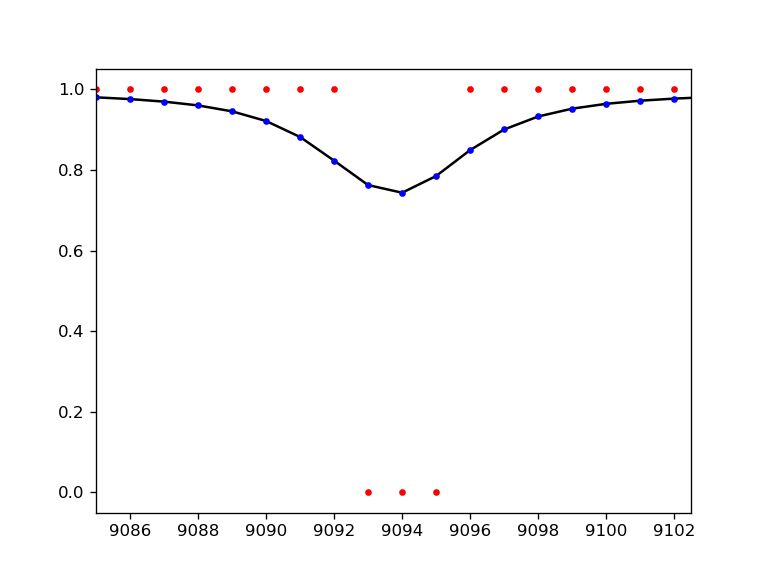

(9085.0, 9102.5)

In [70]:
# Effect of atm.mask_transmission
atm = Atmosphere.from_band("J", bary=False)
depth = 20.0
cutoff = 1 - depth / 100.0
print(cutoff)
plt.figure()
plt.plot(atm.transmission, 'k-')
atm.mask = atm.transmission >= cutoff
plt.plot(atm.transmission, 'b.')
plt.plot(atm.mask, 'r.')
plt.xlim(9085.0, 9102.5)

In [ ]:
# Problems / Future work
# 1. Need to differentiate between fully corrected lines and not fully corrected lines
# 2. The RV precision is in the 100s of m/s in the paper it's in 10s m/s

In [ ]:
# 1. Excluding not fully corrected telluric lines